# Imports & Load Data

In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier

In [2]:
print("Loading Data...")
X_train = pd.read_csv('data/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
X_train_id = pd.read_csv('data/ieee-fraud-detection/train_identity.csv', index_col='TransactionID')
X_train = X_train.merge(X_train_id, how='left', left_index=True, right_index=True)
y_train = X_train['isFraud'].copy()
del X_train['isFraud']

Loading Data...


In [3]:
### 2. Preprocessing ###
print("Preprocessing...")
# Drop high-NA columns (>98% missing)
na_thresh = 0.98
miss = X_train.isnull().mean()
drop_cols = miss[miss > na_thresh].index.tolist()
X_train.drop(drop_cols, axis=1, inplace=True)

Preprocessing...


In [4]:
# Fill missing: median for numeric, "missing" for objects
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col].fillna('missing', inplace=True)
    else:
        X_train[col].fillna(X_train[col].median(), inplace=True)


In [5]:
# Label encode categoricals
for col in X_train.select_dtypes('object').columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str).values)


In [6]:
# Scale for NN
scaler = StandardScaler()
X_all = scaler.fit_transform(X_train)

In [7]:
# Train/val split
Xtr, Xval, ytr, yval = train_test_split(X_all, y_train.values, test_size=0.2, stratify=y_train, random_state=42)

In [8]:
### 3. DNN Deep Feature Extraction ###
print("Training DNN...")
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape=(Xtr.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
deep_features = Dense(32, activation='relu', name="deep_feat")(x)
outputs = Dense(1, activation='sigmoid')(deep_features)
dnn = Model(inputs, outputs)
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Fit like before
dnn.fit(Xtr, ytr, epochs=20, batch_size=8192, validation_data=(Xval, yval),
        callbacks=[EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)])

# Extract deep features for train/val
feature_extractor = Model(inputs=dnn.input, outputs=dnn.get_layer('deep_feat').output)
Xtr_deep = feature_extractor.predict(Xtr, batch_size=2048)
Xval_deep = feature_extractor.predict(Xval, batch_size=2048)


# Combine with input features
hyb_tr = np.hstack([Xtr, Xtr_deep])
hyb_val = np.hstack([Xval, Xval_deep])


Training DNN...
Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-07-25 17:11:36.096904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-25 17:11:36.096927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-07-25 17:11:38.164164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 0.6566 - loss: 0.8679 - val_AUC: 0.5602 - val_loss: 0.1743
Epoch 2/20
 7/58 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.6944 - loss: 0.1449

/Users/tanmaireddy/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - AUC: 0.7250 - loss: 0.1362 - val_AUC: 0.7673 - val_loss: 0.1213
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - AUC: 0.7907 - loss: 0.1196 - val_AUC: 0.8289 - val_loss: 0.1132
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - AUC: 0.8120 - loss: 0.1159 - val_AUC: 0.8459 - val_loss: 0.1104
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - AUC: 0.8266 - loss: 0.1129 - val_AUC: 0.8566 - val_loss: 0.1066
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - AUC: 0.8361 - loss: 0.1097 - val_AUC: 0.8626 - val_loss: 0.1051
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 0.8434 - loss: 0.1067 - val_AUC: 0.8677 - val_loss: 0.1028
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 0.8479 - loss: 0.1052 - val_AUC: 0.8711 - val_loss: 0.1017
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 0.8537 - loss: 0.1028 - val_AUC: 0.8751 - val_loss: 0.0996
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - AUC: 0.8570 - loss: 0

In [9]:
### 4. XGBoost Hybrid Model ###
print("Training XGBoost on hybrid features...")
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.03,
    scale_pos_weight=20,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='auc'
)
xgb.fit(hyb_tr, ytr, eval_set=[(hyb_val, yval)], verbose=10)

# Evaluation
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
pred_val = xgb.predict_proba(hyb_val)[:,1]
print(f"Validation AUC: {roc_auc_score(yval, pred_val):.5f}")
print(classification_report(yval, pred_val > 0.5))
print('Confusion Matrix:\n', confusion_matrix(yval, pred_val > 0.5))


Training XGBoost on hybrid features...
[0]	validation_0-auc:0.89547


/Users/tanmaireddy/miniconda3/envs/tensorflow/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:12:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10]	validation_0-auc:0.90407
[20]	validation_0-auc:0.90642
[30]	validation_0-auc:0.90764
[40]	validation_0-auc:0.90826
[50]	validation_0-auc:0.90847
[60]	validation_0-auc:0.90911
[70]	validation_0-auc:0.90993
[80]	validation_0-auc:0.91099
[90]	validation_0-auc:0.91184
[100]	validation_0-auc:0.91252
[110]	validation_0-auc:0.91324
[120]	validation_0-auc:0.91397
[130]	validation_0-auc:0.91489
[140]	validation_0-auc:0.91550
[150]	validation_0-auc:0.91624
[160]	validation_0-auc:0.91714
[170]	validation_0-auc:0.91806
[180]	validation_0-auc:0.91888
[190]	validation_0-auc:0.91955
[200]	validation_0-auc:0.92033
[210]	validation_0-auc:0.92082
[220]	validation_0-auc:0.92139
[230]	validation_0-auc:0.92204
[240]	validation_0-auc:0.92244
[250]	validation_0-auc:0.92292
[260]	validation_0-auc:0.92356
[270]	validation_0-auc:0.92417
[280]	validation_0-auc:0.92456
[290]	validation_0-auc:0.92491
[299]	validation_0-auc:0.92544
Validation AUC: 0.92544
              precision    recall  f1-score   support



In [10]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix

# yval = true labels, pred_val = probabilities from xgb.predict_proba(...)

# Standard threshold (0.5 by default)
print(classification_report(yval, pred_val > 0.5, digits=4))

# Full ROC-AUC
auc = roc_auc_score(yval, pred_val)
print(f"AUC: {auc:.5f}")

# Show confusion matrix again for clarity
print("Confusion Matrix:\n", confusion_matrix(yval, pred_val > 0.5))


              precision    recall  f1-score   support

           0     0.9905    0.9307    0.9596    113975
           1     0.2826    0.7530    0.4109      4133

    accuracy                         0.9245    118108
   macro avg     0.6365    0.8418    0.6853    118108
weighted avg     0.9657    0.9245    0.9404    118108

AUC: 0.92544
Confusion Matrix:
 [[106074   7901]
 [  1021   3112]]


In [11]:
prec, rec, thresh = precision_recall_curve(yval, pred_val)

f1 = 2 * (prec * rec) / (prec + rec + 1e-10)
best_i = np.argmax(f1)
best_thr = thresh[best_i]
best_f1 = f1[best_i]
print(f"Best F1: {best_f1:.4f} at threshold {best_thr:.3f}")

# Confusion matrix at the best F1 threshold
print(confusion_matrix(yval, pred_val > best_thr))
print(classification_report(yval, pred_val > best_thr, digits=4))


Best F1: 0.6053 at threshold 0.866
[[113140    835]
 [  1978   2155]]
              precision    recall  f1-score   support

           0     0.9828    0.9927    0.9877    113975
           1     0.7207    0.5214    0.6051      4133

    accuracy                         0.9762    118108
   macro avg     0.8518    0.7570    0.7964    118108
weighted avg     0.9736    0.9762    0.9743    118108



## Further Improving the Model

In [12]:
df = X_train.copy()

# Robust CLIENT/UID construction
df['uid'] = (
    df['card1'].astype(str) + '_' +
    df['card2'].astype(str) + '_' +
    df['card3'].astype(str) + '_' +
    df['card5'].astype(str) + '_' +
    df['addr1'].astype(str) + '_' +
    df['P_emaildomain'].astype(str)
)

# UID Frequency: transaction count per UID
df['uid_cnt'] = df.groupby('uid')['uid'].transform('count')

# TransactionAmt statistics (per UID)
df['uid_amt_mean'] = df.groupby('uid')['TransactionAmt'].transform('mean')
df['uid_amt_std']  = df.groupby('uid')['TransactionAmt'].transform('std')
df['uid_amt_min']  = df.groupby('uid')['TransactionAmt'].transform('min')
df['uid_amt_max']  = df.groupby('uid')['TransactionAmt'].transform('max')

# DEVICE grouping (null-handling included)
for col in ['DeviceInfo', 'P_emaildomain']:
    if col in df.columns:
        df[col] = df[col].astype(str)

df['DeviceInfo_group'] = df['DeviceInfo'].replace('nan', 'unknown').str[:6]

# VELOCITY: Transactions per UID per day/hour using TransactionDT as seconds
START_DATE = '2017-12-01'
df['datetime'] = pd.to_datetime(START_DATE) + pd.to_timedelta(df['TransactionDT'], unit='s')
df['day'] = (df['TransactionDT'] // (24*60*60)).astype(int)
df['hour'] = (df['TransactionDT'] // (60*60)).astype(int)
df['uid_day_count'] = df.groupby(['uid', 'day'])['uid'].transform('count')
df['uid_hour_count'] = df.groupby(['uid', 'hour'])['uid'].transform('count')

# TIME DELTA: Time since previous transaction for each UID
df = df.sort_values(['uid', 'TransactionDT'])
df['time_since_last'] = df.groupby('uid')['TransactionDT'].diff().fillna(-1)

# Restore new features to X_train for modeling
X_train = df.copy()

In [13]:
from sklearn.model_selection import GroupKFold

# For user-based generalization:
uid_groups = df['uid'].values
gkf = GroupKFold(n_splits=5)
for train_idx, val_idx in gkf.split(X_train, y_train, groups=uid_groups):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    # fit/evaluate your models here


In [14]:
from sklearn.preprocessing import LabelEncoder

# List of columns to drop from modeling
to_drop = ['uid', 'DeviceInfo', 'DeviceInfo_group', 'datetime']

# Label-encode ALL other object columns for stacking (if you wish to keep them as features)
for col in X_train.select_dtypes(include=['object', 'category']).columns:
    if col not in to_drop:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))

# Drop columns NOT for modeling or that cannot be meaningfully encoded
X_train = X_train.drop(to_drop, axis=1, errors='ignore')
X_val = X_val.drop(to_drop, axis=1, errors='ignore')


/var/folders/yd/rkx6p1w53jvbbdd6rf00bln80000gn/T/ipykernel_28635/3212594302.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = le.transform(X_val[col].astype(str))


In [15]:
assert all([np.issubdtype(dt, np.number) for dt in X_train.dtypes]), "Non-numeric columns remain!"


In [16]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

base_learners = [
    ('xgb', XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='auc', verbosity=0)),
    ('lgbm', LGBMClassifier(n_estimators=200)),
    ('cat', CatBoostClassifier(verbose=0, iterations=200, thread_count=-1))
]

meta_learner = LGBMClassifier(n_estimators=100)
stacked = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1
)
stacked.fit(X_train, y_train)
y_pred = stacked.predict_proba(X_val)[:, 1]


[LightGBM] [Info] Number of positive: 20663, number of negative: 569877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.403620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40023
[LightGBM] [Info] Number of data points in the train set: 590540, number of used features: 431
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034990 -> initscore=-3.317076
[LightGBM] [Info] Start training from score -3.317076
[LightGBM] [Info] Number of positive: 13776, number of negative: 379918
[LightGBM] [Info] Number of positive: 13775, number of negative: 379918
[LightGBM] [Info] Number of positive: 13775, number of negative: 379918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.176118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

/Users/tanmaireddy/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


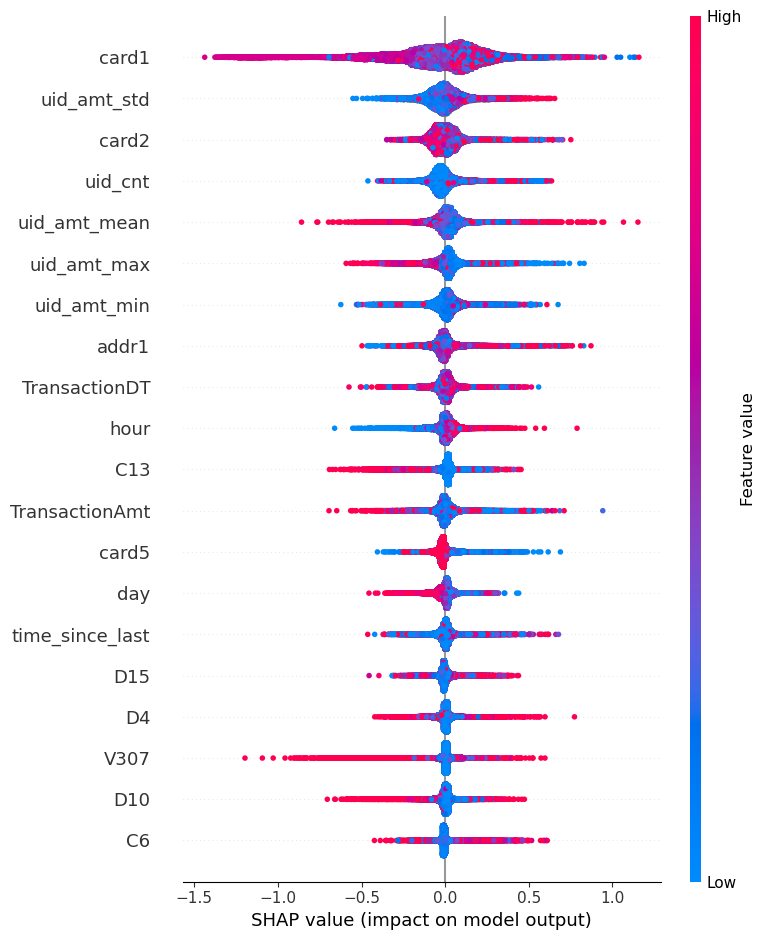

In [17]:
import shap
explainer = shap.TreeExplainer(stacked.named_estimators_['xgb'])
shap_vals = explainer.shap_values(X_val)
shap.summary_plot(shap_vals, X_val, max_display=20)
